In [1]:
! ls IN

diagnosis.csv  edstays.csv  medrecon.csv  pyxis.csv  triage.csv  vitalsign.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def look_n_load(path):
    df = pd.read_csv(path)
    print('\nShape:', df.shape)
    print('\nColumns:', list(df.columns))
#     print('\n',df.describe())
    print('\nMissing proportions:\n', df.isna().sum()/len(df))
    print('\nData:\n', df.head())
    return df

In [3]:
diagnosis = look_n_load('IN/diagnosis.csv')


Shape: (946692, 6)

Columns: ['subject_id', 'stay_id', 'seq_num', 'icd_code', 'icd_version', 'icd_title']

Missing proportions:
 subject_id     0.0
stay_id        0.0
seq_num        0.0
icd_code       0.0
icd_version    0.0
icd_title      0.0
dtype: float64

Data:
    subject_id   stay_id  seq_num icd_code  icd_version  \
0    10000032  32952584        1     4589            9   
1    10000032  32952584        2     7070            9   
2    10000032  32952584        3      V08            9   
3    10000032  33258284        1     5728            9   
4    10000032  33258284        2    78959            9   

                                           icd_title  
0                                    HYPOTENSION NOS  
1  UNSPECIFIED VIRAL HEPATITIS C WITHOUT HEPATIC ...  
2                         ASYMPTOMATIC HIV INFECTION  
3                           OTH SEQUELA, CHR LIV DIS  
4                                      OTHER ASCITES  


Diagnosis table has no missing data in field (fully complete).

Questions:
- None, this looks like the back bone of all sequential data, perhaps look at distributions of subject_ids and/or icd_codes to see multiple readmission rates for persons and diagnoses

In [36]:
diagnosis['upper_icd'] = [x[:3] for x in diagnosis.icd_code]
up_icd_counts = pd.DataFrame(diagnosis['upper_icd'].value_counts()).reset_index()
up_icd_counts = up_icd_counts.rename(columns={'index':'upper_icd', 'upper_icd':'counts'})

n = 5000

print('Total Upper ICD Codes:',
     len(up_icd_counts))
print(f'Upper ICD Codes Above {str(int(n/1000))}k:',
      len(up_icd_counts[up_icd_counts['counts'] > n]))

print('Total diagnoses:', up_icd_counts['counts'].sum())
print(f'Above {str(int(n/1000))}k times:', up_icd_counts[up_icd_counts['counts'] > n]['counts'].sum())

Total Upper ICD Codes: 2157
Upper ICD Codes Above 5k: 46
Total diagnoses: 946692
Above 5k times: 477418


In [119]:
edstays = look_n_load('IN/edstays2.csv')


Shape: (447712, 9)

Columns: ['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'gender', 'race', 'arrival_transport', 'disposition']

Missing proportions:
 subject_id           0.000000
hadm_id              0.522213
stay_id              0.000000
intime               0.000000
outtime              0.000000
gender               0.000000
race                 0.000000
arrival_transport    0.000000
disposition          0.000000
dtype: float64

Data:
    subject_id     hadm_id   stay_id           intime          outtime gender  \
0    10000032  22595853.0  33258284   6/5/2180 19:17   6/5/2180 23:30      F   
1    10000032  22841357.0  38112554  26/6/2180 15:54  26/6/2180 21:31      F   
2    10000032  25742920.0  35968195   5/8/2180 20:58    6/8/2180 1:44      F   
3    10000032  29079034.0  32952584  22/7/2180 16:24   23/7/2180 5:54      F   
4    10000032  29079034.0  39399961   23/7/2180 5:54  23/7/2180 14:00      F   

    race arrival_transport disposition  
0  WHITE         AMB

Edstays table is missing over 50% hadm_id with no metadata on hadm_ids (perhaps redudant)

Questions:
- What are hadm_ids? Presuming there are redundant as this id does not exist in any other table.

- Distributions of categorical variables (simple value_counts and visuals to start), then look into disposition for admission rates/mortality (likely to have NLP problems to solve as there are free text variables describing state of the patient)
- Also use intime/outtime to determine admission rates and length of stay (look at base statistics of each, then break down by categorical variables in edstays) 

In [120]:
# def find_admission(x):
#     if x in ['ADMITTED', 'TRANSFER']:
#         return 1
#     else:
#         return 0

# dispositions_to_keep = ['HOME','ADMITTED','TRANSFER']
    
# edstays = edstays[edstays.disposition.isin(dispositions_to_keep)]

# edstays['admitted'] = edstays['disposition'].apply(find_admission)

In [121]:

if type(edstays['intime'][0]) == type('str'): 
    edstays['intime'] = pd.to_datetime(edstays['intime'])
    edstays['outtime'] = pd.to_datetime(edstays['outtime'])

    edstays['difftime'] = edstays['outtime'] - edstays['intime']
    edstays['nights'] = [x.days for x in edstays.difftime]
    edstays['hours'] = [round(x.total_seconds() / 60 / 60, 1) for x in edstays.difftime]

    # need to ensure exact time of dishcarge has been maintained and only the date ambiguated 
    edstays['discharge_hour'] = [x.hour for x in edstays.outtime]
    edstays['admission_hour'] = [x.hour for x in edstays.intime]

    edstays['admission_date'] = [x.date() for x in edstays.intime]
    edstays['admission_day'] = [x.day for x in edstays.intime]

patients_seen = pd.DataFrame(edstays['admission_date'].value_counts()).reset_index()
patients_seen = patients_seen.rename(columns={'index':'admission_date', 'admission_date':'patients_seen'})

admitted_patients = edstays[edstays['admitted']==1]
hospital_capacity = pd.DataFrame(admitted_patients['admission_date'].value_counts()).reset_index()
hospital_capacity = hospital_capacity.rename(columns={'index':'admission_date', 'admission_date':'capacity'})

edstays
# # overnight stays, not just hours

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,admitted,difftime,nights,hours,discharge_hour,admission_hour,admission_date,admission_day
0,10000032,22595853.0,33258284,2180-06-05 19:17:00,2180-06-05 23:30:00,F,WHITE,AMBULANCE,ADMITTED,1,0 days 04:13:00,0,4.2,23,19,2180-06-05,5
1,10000032,22841357.0,38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,F,WHITE,AMBULANCE,ADMITTED,1,0 days 05:37:00,0,5.6,21,15,2180-06-26,26
2,10000032,25742920.0,35968195,2180-05-08 20:58:00,2180-06-08 01:44:00,F,WHITE,AMBULANCE,ADMITTED,1,30 days 04:46:00,30,724.8,1,20,2180-05-08,8
3,10000032,29079034.0,32952584,2180-07-22 16:24:00,2180-07-23 05:54:00,F,WHITE,AMBULANCE,HOME,0,0 days 13:30:00,0,13.5,5,16,2180-07-22,22
4,10000032,29079034.0,39399961,2180-07-23 05:54:00,2180-07-23 14:00:00,F,WHITE,AMBULANCE,ADMITTED,1,0 days 08:06:00,0,8.1,14,5,2180-07-23,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447706,19999784,25715748.0,34149746,2119-11-08 09:15:00,2119-11-08 13:40:00,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,1,0 days 04:25:00,0,4.4,13,9,2119-11-08,8
447707,19999784,26194817.0,35692999,2119-06-18 14:21:00,2119-06-18 21:09:00,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,1,0 days 06:48:00,0,6.8,21,14,2119-06-18,18
447708,19999828,25744818.0,32917002,2149-08-01 09:11:00,2149-08-01 18:12:00,F,WHITE,AMBULANCE,ADMITTED,1,0 days 09:01:00,0,9.0,18,9,2149-08-01,1
447709,19999828,29734428.0,30712109,2147-07-17 17:18:00,2147-07-18 17:34:00,F,WHITE,WALK IN,ADMITTED,1,1 days 00:16:00,1,24.3,17,17,2147-07-17,17


In [122]:
edstays.to_csv('edstays2.csv')

In [132]:
edstays['admission_day_of_week'] = [x.weekday() for x in edstays.intime]


0    61595
3    61427
1    61363
2    61357
6    61009
4    60910
5    60623
Name: admission_day_of_week, dtype: int64

In [54]:
edstays

/home/das/anaconda3/envs/gdal_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [56]:
edstays_sub[['disposition','admitted']].value_counts() # check that it's 1:1 (therefore it worked!)

disposition  admitted
HOME         0           254545
ADMITTED     1           166303
TRANSFER     1             7436
dtype: int64

In [57]:
edstays_sub[['admitted']].value_counts()

admitted
0           254545
1           173739
dtype: int64

In [87]:
    
def cross_tab_ratio(df, x, y='admitted'):
    rename_these = {
        0: 'home',
        1: 'admitted'
    }
    ctab = pd.crosstab(df[x], df[y]).reset_index().rename(columns=rename_these)
    ctab['total'] = ctab['admitted'] + ctab['home']
    ctab['ratio'] = round(ctab['admitted'] / (ctab['total']),3)
    
    print(ctab.plot.bar(x, 'ratio'))
    return ctab
    

AxesSubplot(0.125,0.125;0.775x0.755)


admitted,race,home,admitted,total,ratio
27,UNKNOWN,775,4414,5189,0.851
26,UNABLE TO OBTAIN,31,176,207,0.850
24,PORTUGUESE,626,826,1452,0.569
32,WHITE - RUSSIAN,3157,3056,6213,0.492
28,WHITE,123963,107324,231287,0.464
5,ASIAN - SOUTH EAST ASIAN,852,724,1576,0.459
0,AMERICAN INDIAN/ALASKA NATIVE,578,486,1064,0.457
31,WHITE - OTHER EUROPEAN,5041,4149,9190,0.451
30,WHITE - EASTERN EUROPEAN,746,598,1344,0.445
21,NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,295,207,502,0.412


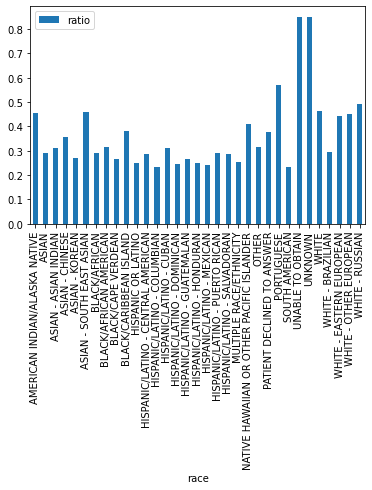

In [125]:
cross_tab_ratio(edstays_sub, 'race').sort_values('ratio', ascending=False)

AxesSubplot(0.125,0.125;0.775x0.755)


admitted,gender,home,admitted,total,ratio
0,F,143894,89156,233050,0.383
1,M,110651,84583,195234,0.433


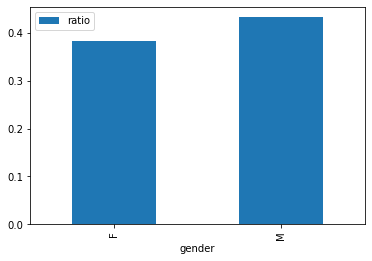

In [89]:
cross_tab_ratio(edstays_sub, 'gender')

AxesSubplot(0.125,0.125;0.775x0.755)


admitted,arrival_transport,home,admitted,total,ratio
0,AMBULANCE,68335,90959,159294,0.571
1,HELICOPTER,48,805,853,0.944
2,OTHER,856,474,1330,0.356
3,UNKNOWN,1184,6974,8158,0.855
4,WALK IN,184122,74527,258649,0.288


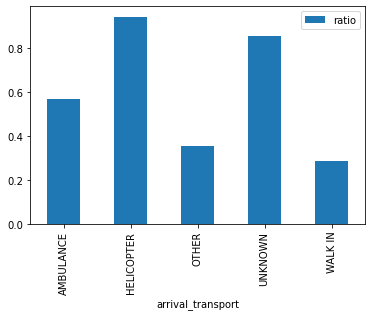

In [90]:
cross_tab_ratio(edstays_sub, 'arrival_transport')

AxesSubplot(0.125,0.125;0.775x0.755)


admitted,admission_day_of_week,home,admitted,total,ratio
0,0,36887,24708,61595,0.401
1,1,36281,25082,61363,0.409
2,2,36541,24816,61357,0.404
3,3,36390,25037,61427,0.408
4,4,36337,24573,60910,0.403
5,5,36036,24587,60623,0.406
6,6,36073,24936,61009,0.409


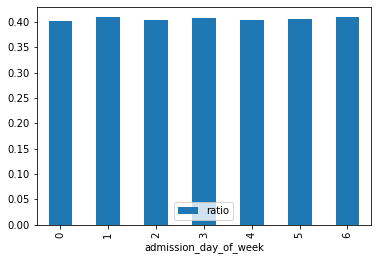

In [135]:
cross_tab_ratio(edstays, 'admission_day_of_week')

In [66]:
patient_assessments = edstays.subject_id.value_counts()
patient_assessments = pd.DataFrame(patient_stays.reset_index()).rename(columns={'index':'subject_id','subject_id':'assessments'})
# subject_id 15496609 admitted 321 times
patient_assessments['assessments'] = pd.to_numeric(patient_assessments['assessments'])
patient_assessments

,subject_id,assessments
0,15496609,321
1,16233333,210
2,16662316,184
3,14394983,170
4,17903094,167
...,...,...
216368,13983197,1
216369,14154545,1
216370,13966805,1
216371,16590290,1


In [65]:
# [x for x in edstays[edstays.subject_id==15496609].disposition]
edstays[edstays.subject_id==15496609].arrival_transport.value_counts()

# a lot of being sent HOME

AMBULANCE    298
WALK IN       18
UNKNOWN        5
Name: arrival_transport, dtype: int64

In [41]:
pd.crosstab(edstays.arrival_transport, edstays.disposition, normalize='index')

disposition,ADMITTED,ELOPED,EXPIRED,HOME,LEFT AGAINST MEDICAL ADVICE,LEFT WITHOUT BEING SEEN,OTHER,TRANSFER
arrival_transport,,,,,,,,
AMBULANCE,0.529468,0.010736,0.001903,0.416834,0.004776,0.001244,0.009668,0.025369
HELICOPTER,0.887417,0.001104,0.019868,0.052980,0.002208,0.000000,0.035320,0.001104
OTHER,0.314706,0.009559,0.000000,0.629412,0.002941,0.000735,0.008824,0.033824
UNKNOWN,0.414471,0.074088,0.002041,0.073222,0.005009,0.315646,0.098701,0.016821
WALK IN,0.269728,0.011453,0.000121,0.693915,0.004206,0.004549,0.004881,0.011148


In [38]:
edstays.groupby(['arrival_transport', 'disposition']).size()

arrival_transport  disposition                
AMBULANCE          ADMITTED                        86800
                   ELOPED                           1760
                   EXPIRED                           312
                   HOME                            68335
                   LEFT AGAINST MEDICAL ADVICE       783
                   LEFT WITHOUT BEING SEEN           204
                   OTHER                            1585
                   TRANSFER                         4159
HELICOPTER         ADMITTED                          804
                   ELOPED                              1
                   EXPIRED                            18
                   HOME                               48
                   LEFT AGAINST MEDICAL ADVICE         2
                   OTHER                              32
                   TRANSFER                            1
OTHER              ADMITTED                          428
                   ELOPED                

In [67]:
medrecon = look_n_load('IN/medrecon.csv')


Shape: (3143791, 9)

Columns: ['subject_id', 'stay_id', 'charttime', 'name', 'gsn', 'ndc', 'etc_rn', 'etccode', 'etcdescription']

Missing proportions:
 subject_id        0.000000
stay_id           0.000000
charttime         0.000000
name              0.000000
gsn               0.000000
ndc               0.000000
etc_rn            0.000000
etccode           0.003938
etcdescription    0.003938
dtype: float64

Data:
    subject_id   stay_id            charttime  \
0    10000032  32952584  2180-07-22 17:26:00   
1    10000032  32952584  2180-07-22 17:26:00   
2    10000032  32952584  2180-07-22 17:26:00   
3    10000032  32952584  2180-07-22 17:26:00   
4    10000032  32952584  2180-07-22 17:26:00   

                                name    gsn          ndc  etc_rn  etccode  \
0                  albuterol sulfate  28090  21695042308       1   5970.0   
1                  calcium carbonate   1340  10135021101       1    733.0   
2       cholecalciferol (vitamin D3)  65241  37205024678    

Medrecon table is only missing 0.3% of etccode and etcdescription (likely 1:1 missing data)

Questions:
- What is gsn and ndc? Is gsn a foreign ID for pyxis?

In [68]:
pyxis = look_n_load('IN/pyxis.csv')


Shape: (1670590, 7)

Columns: ['subject_id', 'stay_id', 'charttime', 'med_rn', 'name', 'gsn_rn', 'gsn']

Missing proportions:
 subject_id    0.000000
stay_id       0.000000
charttime     0.000000
med_rn        0.000000
name          0.000000
gsn_rn        0.000000
gsn           0.022311
dtype: float64

Data:
    subject_id   stay_id            charttime  med_rn  \
0    10000032  32952584  2180-07-22 17:59:00       1   
1    10000032  32952584  2180-07-22 17:59:00       1   
2    10000032  35968195  2180-08-05 22:29:00       1   
3    10000032  35968195  2180-08-05 22:55:00       2   
4    10000032  35968195  2180-08-05 22:55:00       3   

                               name  gsn_rn      gsn  
0                 Albuterol Inhaler       1   5037.0  
1                 Albuterol Inhaler       2  28090.0  
2                          Morphine       1   4080.0  
3                 Donnatol (Elixir)       1   4773.0  
4  Aluminum-Magnesium Hydrox.-Simet       1   2701.0  


Pyxis only missing 2.2% of gsn otherwise complete.

Questions:
- How does medical information change between the categorical variables in edstays and admission/mortality rates?

In [75]:
pyxis.name.value_counts()

Ondansetron                         89726
Acetaminophen                       48163
Lorazepam                           46465
Ondansetron 4mg/2mL 2mL VIAL        43340
Morphine Sulfate                    42079
                                    ...  
Chlordiazepoxide 25mg CAP               1
Cortisporin Otic Susp 10mL DBTL         1
Diphenoxylate-Atropine 5mL CUP          1
Senna 8.8mg/5mL Syrup                   1
LACOsamide 100mg/100mL 100mL Bag        1
Name: name, Length: 1104, dtype: int64

In [69]:
triage = look_n_load('IN/triage.csv')


Shape: (447712, 11)

Columns: ['subject_id', 'stay_id', 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 'chiefcomplaint']

Missing proportions:
 subject_id        0.000000
stay_id           0.000000
temperature       0.054935
heartrate         0.040111
resprate          0.047743
o2sat             0.048355
sbp               0.042941
dbp               0.044823
pain              0.030415
acuity            0.016368
chiefcomplaint    0.000051
dtype: float64

Data:
    subject_id   stay_id  temperature  heartrate  resprate  o2sat    sbp   dbp  \
0    10000032  32952584         97.8       87.0      14.0   97.0   71.0  43.0   
1    10000032  33258284         98.4       70.0      16.0   97.0  106.0  63.0   
2    10000032  35968195         99.4      105.0      18.0   96.0  106.0  57.0   
3    10000032  38112554         98.9       88.0      18.0   97.0  116.0  88.0   
4    10000032  39399961         98.7       77.0      16.0   98.0   96.0  50.0   

  pain  acuity

Triage is mostly complete with ~5-6% at most missing from any given variable.

Questions:
- How is chiefcomplaint structured? How can we create features from free text?
- Are there any autocorrelative variables (likely), do exceptions to these correlations mean something for admission/length of stay/mortality?

In [78]:
triage.chiefcomplaint = [str(x).upper() for x in triage.chiefcomplaint]
triage.chiefcomplaint.value_counts()

ABD PAIN                                 16601
CHEST PAIN                               14619
S/P FALL                                  7902
DYSPNEA                                   7758
HEADACHE                                  5377
                                         ...  
ABD PAIN, DIARRHEA, URINARY RETENTION        1
S/P MVC LEFT KNEE PAIN                       1
HEMATEMESIS, N/V, PREGNANT                   1
LEFT WRIST INFECTION                         1
ABD PAIN, BRBPR, MELENA                      1
Name: chiefcomplaint, Length: 61228, dtype: int64

In [70]:
vitalsign = look_n_load('IN/vitalsign.csv')


Shape: (1646976, 11)

Columns: ['subject_id', 'stay_id', 'charttime', 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'rhythm', 'pain']

Missing proportions:
 subject_id     0.000000
stay_id        0.000000
charttime      0.000000
temperature    0.360779
heartrate      0.044546
resprate       0.057115
o2sat          0.086914
sbp            0.051936
dbp            0.051936
rhythm         0.961874
pain           0.283495
dtype: float64

Data:
    subject_id   stay_id            charttime  temperature  heartrate  \
0    10000032  32952584  2180-07-22 16:36:00          NaN       83.0   
1    10000032  32952584  2180-07-22 16:43:00          NaN       85.0   
2    10000032  32952584  2180-07-22 16:45:00          NaN       84.0   
3    10000032  32952584  2180-07-22 17:56:00          NaN       84.0   
4    10000032  32952584  2180-07-22 18:37:00         98.4       86.0   

   resprate  o2sat   sbp   dbp rhythm pain  
0      24.0   97.0  90.0  51.0    NaN    0  
1      22.0   9

Vitalsigns is missing almost all rhythm data (96%) and over a third (36%) of temperature data, is this expected? 

In [88]:
import numpy as np

vitalsign_agg = vitalsign.groupby(['subject_id', 'stay_id']).agg({
    "temperature": ['count', 'min','mean','max', np.std],
    "heartrate": ['count', 'min','mean','max', np.std],
    "resprate": ['count', 'min','mean','max', np.std],
    "o2sat": ['count', 'min','mean','max', np.std],
    "sbp": ['count', 'min','mean','max', np.std],
    "dbp": ['count', 'min','mean','max', np.std]
#     "rhythm": ['count', 'min','mean','max', np.std],
#     "pain": ['count', 'min','mean','max', np.std]
})

vitalsign_agg

temperature                               heartrate  \
                          count   min    mean   max       std     count   
subject_id stay_id                                                        
10000032   32952584           2  98.2  98.300  98.4  0.141421         7   
           33258284           1  97.7  97.700  97.7       NaN         1   
           35968195           2  98.1  98.300  98.5  0.282843         2   
           38112554           2  97.9  97.900  97.9  0.000000         2   
           39399961           2  98.1  98.550  99.0  0.636396        11   
...                         ...   ...     ...   ...       ...       ...   
19999784   37972930           4  97.4  97.850  98.1  0.310913         4   
19999828   30712109           8  97.9  98.825  99.7  0.688165         9   
           32917002           6  96.6  97.700  98.1  0.583095         7   
19999914   32002659           1  99.5  99.500  99.5       NaN         1   
19999987   34731548           1  99.3  99.300  99.3       NaN         3   

                                                         ...   sbp         \
                       min        mean    max       std  ... count    min   
subject_id stay_id                                       ...                
10000032   32952584   83.0   84.571429   86.0  0.975900  ...     7   65.0   
           33258284   79.0   79.000000   79.0       NaN  ...     1  107.0   
           35968195   91.0   93.500000   96.0  3.535534  ...     2   98.0   
           38112554   76.0   81.000000   86.0  7.071068  ...     2   95.0   
           39399961   78.0   85.727273   96.0  6.842381  ...    11   73.0   
...                    ...         ...    ...       ...  ...   ...    ...   
19999784   37972930   68.0   79.250000   91.0  9.708244  ...     4  139.0   
19999828   30712109   65.0   74.666667   83.0  6.500000  ...     9   87.0   
           32917002   98.0  104.714286  112.0  4.608481  ...     7  110.0   
19999914   32002659   81.0   81.000000   81.0       NaN  ...     1   93.0   
19999987   34731548  103.0  108.666667  112.0  4.932883  ...     3  113.0   

                                                   dbp                         \
                           mean    max       std count   min       mean   max   
subject_id stay_id                                                              
10000032   32952584   79.428571   90.0  8.263517     7  37.0  42.857143  51.0   
           33258284  107.000000  107.0       NaN     1  60.0  60.000000  60.0   
           35968195  100.000000  102.0  2.828427     2  58.0  59.000000  60.0   
           38112554   95.500000   96.0  0.707107     2  57.0  60.500000  64.0   
           39399961   84.181818   93.0  6.161464    11  40.0  50.545455  57.0   
...                         ...    ...       ...   ...   ...        ...   ...   
19999784   37972930  142.500000  148.0  3.872983     4  76.0  83.500000  90.0   
19999828   30712109   95.555556  108.0  7.178285     9  54.0  63.888889  87.0   
           32917002  119.428571  129.0  7.412987     7  71.0  79.000000  86.0   
19999914   32002659   93.000000   93.0       NaN     1  55.0  55.000000  55.0   
19999987   34731548  118.000000  123.0  5.000000     3  79.0  81.333333  83.0   

                                
                           std  
subject_id stay_id              
10000032   32952584   6.121780  
           33258284        NaN  
           35968195   1.414214  
           38112554   4.949747  
           39399961   5.465595  
...                        ...  
19999784   37972930   6.608076  
19999828   30712109  10.763880  
           32917002   5.656854  
19999914   32002659        NaN  
19999987   34731548   2.081666  

[429839 rows x 30 columns]

In [90]:
vitalsign.rhythm.value_counts()

Sinus Rhythm                                        19832
Normal Sinus Rhythm                                 13024
Atrial Fibrillation                                  5512
Sinus Tachycardia                                    5426
Sinus Bradycardia                                    3425
                                                    ...  
atrial ventrical paced                                  1
Afib with rare pvc, occ pacer captures a/v paced        1
Atrial Fib                                              1
1&deg; AV Block99                                       1
PVC's/Trigeminy                                         1
Name: rhythm, Length: 1218, dtype: int64

In [91]:
vitalsign.pain.value_counts()

0                  589848
5                   65264
8                   60744
4                   53816
2                   50742
                    ...  
" my occiput"           1
kinda hurts             1
unable- present         1
"little HA"             1
unable critical         1
Name: pain, Length: 3234, dtype: int64